# Performance Figure
This notebook collects results from different GCN Multi-Omics trainings as well as HotNet2 and MutSigCV. It then shows the performance of all those methods as a scatterplot.
Each method in this plot represents a point and its coordinates represent the performance of it.
The x-axis depicts the performance on the known cancer genes (training + set set for GCN) and the y-axis depicts the performance on the candidate cancer genes from the NCG.

**Different metrics can be chosen to measure the performance. Currently, precision, recall, AUPR and F1 score can be used.**

Metrics:

* Precision measures the fraction of cancer genes out of all genes that were predicted by the algorithm
* Recall measures the fraction of cancer genes that were found (out of all the cancer genes)
* AUPR measures the area under the precision recall curve, so it incorporates both scores

In [1]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing
sys.path.append(os.path.abspath('../pagerank'))
import pagerank

import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import upsetplot
import scipy
import seaborn as sns
%matplotlib inline

## Relevant Paths
* `ncg_cancer_gene_path`: The path where NCG known cancer genes and candidate cancer genes are stored
* `oncokb_cancer_gene_path`: The path where the oncoKB database is stored
* `baileyetal_cancer_gene_path`: The path where cancer genes from Bailey et al., 2018 are stored
* `driverdb_cancer_gene_path`: The path to the driverDB database folder. It should contain subfolders for the different evidence types (`mutation_download_tab`, `CNV_download_tab` or `methylation_download_tab`)
* `ongene_oncogenes_path`: The path to ONGene oncogenes
* `tsgene_tsgs_path`: The path to TSGene tumor suppressor genes
* `digsee_*_path`: The path to cancer genes from DigSEE. They did literature-mining based on evidence and therefore, there are 3 different subfolders for gene expression, DNA methylation and mutation derived cancer genes

In [2]:
ncg_cancer_gene_path = '../data/pancancer/NCG/cancergenes_list.txt'
oncokb_cancer_gene_path = '/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt'
baileyetal_cancer_gene_path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'
driverdb_cancer_gene_path = '../data/pancancer/driverdb/'
ongene_oncogenes_path = '../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
tsgene_tsgs_path = '../data/pancancer/ongene_tsgene/Human_TSGs.txt'
digsee_expression_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/expression/'
digsee_mutation_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/mutation/'
digsee_methylation_path = '/project/gcn/diseasegcn/data/pancancer/digSEE/methylation/'

## Directories of Stored EMOGI Models

In [3]:
# get metrics from different multi-omics trainings
#dir_multinet = '../data/GCN/training/final_TCGA_all_networks/Multinet/'
#dir_cpdb = '../data/GCN/training/final_TCGA_all_networks/CPDB/'
#dir_iref = '../data/GCN/training/final_TCGA_all_networks/IRefIndex_old/'
#dir_string = '../data/GCN/training/final_TCGA_all_networks/STRING-db/'
#dir_irefnew = '../data/GCN/training/final_TCGA_all_networks/IRefIndex/'
#dir_pcnet = '../data/GCN/training/final_TCGA_all_networks/PCNet/'
dir_multinet = '../data/GCN/training/Rev1_CNA_separated_all_networks/Multinet/'
dir_cpdb = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
dir_iref = '../data/GCN/training/Rev1_CNA_separated_all_networks/IRefIndex_2015/'
dir_string = '../data/GCN/training/Rev1_CNA_separated_all_networks/STRINGdb/'
dir_irefnew = '../data/GCN/training/Rev1_CNA_separated_all_networks/IRefIndex/'
dir_pcnet = '../data/GCN/training/Rev1_CNA_separated_all_networks/PCNet/'
single_omics_dir = '../data/GCN/training/leaveoneout_omics_CPDB_rev1/' #2020_10_16_18_53_06/ #2020_10_09_12_49_28/ # 2020_10_04_19_46_14

In [4]:
def get_metrics_for_training(data_dir, metric='recall', negatives=False, independent_datasets=False, errorbars=False):
    all_metrics = []
    data_types = []
    for d in os.listdir(data_dir):
        training_dir = os.path.join(data_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            metrics = get_metrics_for_single_training(training_dir, negatives=negatives, metric=metric,
                                                      independent_datasets=independent_datasets,
                                                      errorbars=errorbars
                                                     )
            all_metrics.append(metrics)
            data_types.append(d)
    return all_metrics, data_types

def get_metrics_for_single_training(training_dir, metric='recall', negatives=False, independent_datasets='main', errorbars=False):
    if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
        cv_runs = gcnIO.load_hyper_params(training_dir)[0]['cv_runs']
        data = postprocessing.get_training_data(training_dir)
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        pred = postprocessing.get_predictions(training_dir)
        cutoff = postprocessing.get_optimal_cutoff(pred, node_names, test_mask, y_test, method='IS')
        ncg_known, ncg_cand, oncoKB, ongene, bailey = get_cancer_genes_for_net(training_dir)

        if negatives:
            test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
            genes_negtest = node_names[test_neg, 1] # get the gene names
        else:
            genes_negtest = None

        if errorbars:
            ncg_known_metric = []
            oncokb_metric = []
            ncg_cand_metric = []
            for run in range(1, cv_runs+1):
                ncg_known_local, _ = postprocessing.get_metric_score(pred, node_names, ncg_known, ncg_known,
                                                                               cutoff, negatives=genes_negtest,
                                                                               metric=metric,
                                                                               colname='Prob_pos_{}'.format(run))
                oncokb_local, ncg_cand_local = postprocessing.get_metric_score(pred, node_names, oncoKB, ncg_cand,
                                                                               cutoff, negatives=genes_negtest,
                                                                               metric=metric,
                                                                               colname='Prob_pos_{}'.format(run))
                ncg_known_metric.append(ncg_known_local)
                oncokb_metric.append(oncokb_local)
                ncg_cand_metric.append(ncg_cand_local)
        else:
            oncokb_metric, ncg_cand_metric = postprocessing.get_metric_score(pred, node_names, oncoKB, ncg_cand,
                                                                             cutoff, negatives=genes_negtest, metric=metric)
        if independent_datasets:
            if errorbars:
                ongene_metric = []
                bailey_metric = []
                for run in range(1, cv_runs+1):
                    ongene_loc, bailey_loc = postprocessing.get_metric_score(pred, node_names, ongene, bailey,
                                                                         cutoff,
                                                                         negatives=genes_negtest,
                                                                         metric=metric,
                                                                         colname='Prob_pos_{}'.format(run)
                                                                        )
                    ongene_metric.append(ongene_loc)
                    bailey_metric.append(bailey_loc)
            else:
                ongene_metric, bailey_metric = postprocessing.get_metric_score(pred, node_names, ongene,
                                                                           bailey, cutoff, genes_negtest,
                                                                           metric
                                                                          )
            return ncg_known_metric, ncg_cand_metric, oncokb_metric, ongene_metric, bailey_metric
        else:
            return ncg_known_metric, ncg_cand_metric
        

def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)
    # to exclude them from other databases
    known_drivers = nodes[np.logical_or(np.logical_or(y_train.reshape(-1), y_test.reshape(-1)), y_val.reshape(-1))].Name
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open(ncg_cancer_gene_path, 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv(oncokb_cancer_gene_path, sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    candidate_cancer_genes_innet = candidate_cancer_genes_innet[~candidate_cancer_genes_innet.isin(oncokb_no_ncg)]
    #oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    
    # ONGene oncogenes
    oncogenes = pd.read_csv(ongene_oncogenes_path, sep='\t')
    oncogenes_innet = nodes[nodes.Name.isin(oncogenes.OncogeneName)].Name
    oncogenes_final = oncogenes_innet[~oncogenes_innet.isin(known_drivers)]
    
    # Drivers Bailey et al.
    bailey = pd.read_csv(baileyetal_cancer_gene_path, sep='\t', header=3)
    bailey = pd.Series(bailey.Gene.unique())
    bailey_notrain = bailey[~bailey.isin(known_drivers)]
    bailey_final = nodes[nodes.Name.isin(bailey_notrain)].Name

    return known_cancer_genes_innet, candidate_cancer_genes_innet, oncokb_innet, oncogenes_final, bailey_final


def _get_digsee_genes(base_dir, nodes, to_be_removed, threshold):
    pan_cancer_genes = []
    for f in os.listdir(base_dir):
        if f.startswith('mutation') or f.startswith('expression') or f.startswith('methylation'):
            ctype = f.split('.')[0].split('_')[1]
            fname = os.path.join(base_dir, f)
            evidence = pd.read_csv(fname, sep='\t')
            high_scores = evidence[evidence['EVIDENCE SENTENCE SCORE'] >= threshold]
            pan_cancer_genes += high_scores['GENE SYMBOL'].tolist()
    pan_cancer_genes_filtered = [i for i in pan_cancer_genes if not i in to_be_removed]
    return nodes[nodes.Name.isin(pan_cancer_genes)].Name


def get_all_digsee_sets(train_dir, threshold=0.3):
    if train_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(train_dir)
    else:
        data = postprocessing.get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    to_be_removed = nodes[np.logical_or(np.logical_or(y_train.reshape(-1), y_test.reshape(-1)), y_val.reshape(-1))].Name
    
    expr_genes = _get_digsee_genes(digsee_expression_path, nodes, to_be_removed, threshold)
    """
    meth_genes = _get_digsee_genes(digsee_methylation_path, nodes, to_be_removed, threshold)
    muta_genes = _get_digsee_genes(digsee_mutation_path, nodes, to_be_removed, threshold)
    """
    
    oncogenes = pd.read_csv(ongene_oncogenes_path, sep='\t')
    oncogenes_innet = nodes[nodes.Name.isin(oncogenes.OncogeneName)].Name
    oncogenes_final = oncogenes_innet[~oncogenes_innet.isin(to_be_removed)]
    
    bailey = pd.read_csv(baileyetal_cancer_gene_path, sep='\t', header=3)
    bailey = pd.Series(bailey.Gene.unique())
    bailey_notrain = bailey[~bailey.isin(to_be_removed)]
    bailey_final = nodes[nodes.Name.isin(bailey_notrain)].Name
    
    return oncogenes_final, bailey_final, expr_genes



def compute_metric(y_true, y_pred, metric='aupr', cutoff=0.5):
    if metric == 'recall':
        return recall_score(y_true=y_true, y_pred=y_pred >= cutoff)
    elif metric == 'aupr':
        return average_precision_score(y_true=y_true, y_score=y_pred)
    elif metric == 'auroc':
        return roc_auc_score(y_true=y_true, y_score=y_pred)
    elif metric == 'precision':
        return precision_score(y_true=y_true, y_pred=y_pred >= cutoff)
    else:
        print ("Metric {} unknown!".format(metric))
        return None

def get_threshold(y_true, y_pred):
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold

## Overlap of Gene Sets

In [5]:
cancer_gene_sets = postprocessing.get_all_cancer_gene_sets(ncg_path='../data/pancancer/NCG/cancergenes_list.txt',
                                                           oncoKB_path='../data/pancancer/oncoKB/cancerGeneList.txt',
                                                           baileyetal_path='../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv',
                                                           ongene_path='../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
                                                          )
ncg_knowns = cancer_gene_sets[0]
ncg_candidates = cancer_gene_sets[1]
oncoKB_genes = cancer_gene_sets[2]
baileyetal = cancer_gene_sets[3]
oncogenes = cancer_gene_sets[4]

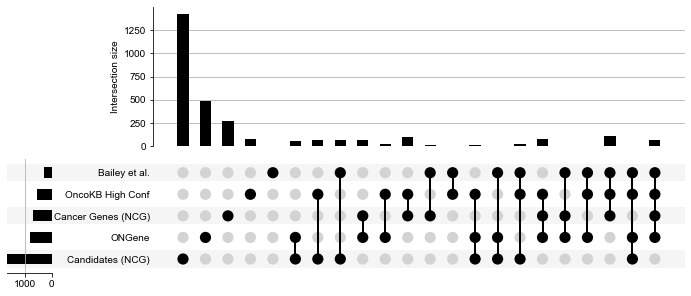

In [6]:
fig = plt.figure(figsize=(30, 20))
cancer_gene_set_dict = {#'DriverDB': list(driverdb_genes),
                        'ONGene': list(oncogenes),
                        #'TSGene': list(tsgs.GeneSymbol),
                        'Cancer Genes (NCG)': ncg_knowns,
                        'Candidates (NCG)': ncg_candidates,
                        'Bailey et al.': baileyetal,
                        'OncoKB High Conf': oncoKB_genes
                        #'COSMIC CGC': cgc
                       }
contents = upsetplot.from_contents(cancer_gene_set_dict)
_ = upsetplot.plot(contents, subset_size='auto', fig=fig)
fig.savefig('../data/pancancer/overlap_independent_cancergenesets.svg')

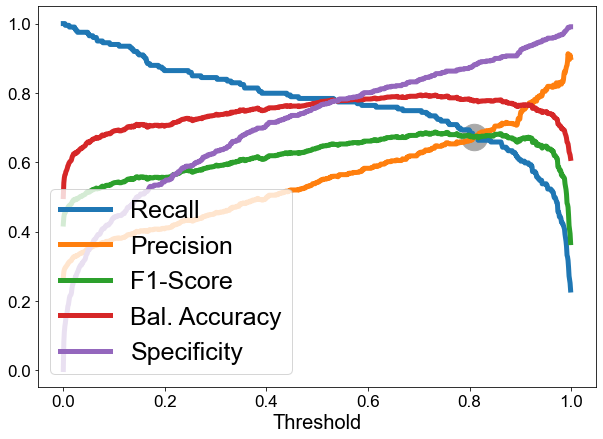

In [7]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_pred).ravel()
    return tn / (tn + fp)

pred = postprocessing.get_predictions(dir_cpdb)
data = postprocessing.get_training_data(dir_cpdb)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data

pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
y_true = pred_test.label
y_score = pred_test['Mean_Pred']

cutoff_vals = np.linspace(0, .999, 1000)
all_recall = []
for cutoff in cutoff_vals:
    r = recall_score(y_true=y_true, y_pred=y_score > cutoff)
    all_recall.append(r)

all_specificity = []
for cutoff in cutoff_vals:
    s = specificity_score(y_true=y_true, y_pred=y_score > cutoff)
    all_specificity.append(s)

all_precision = []
for cutoff in cutoff_vals:
    p = precision_score(y_true=y_true, y_pred=y_score > cutoff)
    all_precision.append(p)

all_fscores = []
for cutoff in cutoff_vals:
    f = f1_score(y_true=y_true, y_pred=y_score > cutoff)
    all_fscores.append(f)

all_accuracy = []
for cutoff in cutoff_vals:
    a = balanced_accuracy_score(y_true=y_true, y_pred=y_score > cutoff)
    all_accuracy.append(a)

diffs = np.abs(np.array(all_precision) - np.array(all_recall))
#diffs = np.abs(np.array(all_specificity) - np.array(all_recall))
best_cutoff = cutoff_vals[diffs.argmin()]
#p_y = (specificity_score(y_true, y_score > best_cutoff) + recall_score(y_true, y_score > best_cutoff)) / 2.
p_y = (precision_score(y_true, y_score > best_cutoff) + recall_score(y_true, y_score > best_cutoff)) / 2.

fig = plt.figure(figsize=(10, 7))
plt.plot(cutoff_vals, all_recall, lw=5, label='Recall')
plt.plot(cutoff_vals, all_precision, lw=5, label='Precision')
plt.plot(cutoff_vals, all_fscores, lw=5, label='F1-Score')
plt.plot(cutoff_vals, all_accuracy, lw=5, label='Bal. Accuracy')
plt.plot(cutoff_vals, all_specificity, lw=5, label='Specificity')
plt.legend(fontsize=25, loc='lower left')
plt.xlabel('Threshold', fontsize=20)
plt.tick_params(axis='both', labelsize=17)
plt.scatter(best_cutoff, p_y, s=700, c='darkgrey', alpha=1)

fig.savefig(os.path.join(dir_cpdb, 'intersection_precision_recall.svg'))

In [8]:
best_cutoff

0.809

## Overlap of Cancer Gene Predictions for the CPDB PPI Network

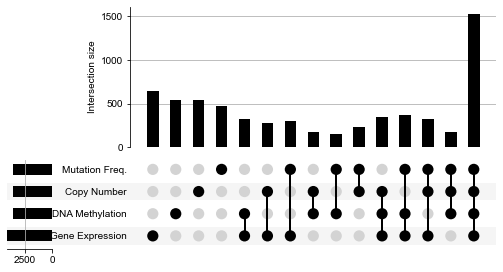

In [15]:
mapping_omics = {'expression': 'Gene Expression', 'methylation': 'DNA Methylation',
                'mutations': 'Mutation Freq.', 'cnas': 'Copy Number', 'multiomics': 'Multi-Omics'
                #'mutation_expression': 'Mutations & Expression',
                #'methylation_expression': 'DNA Meth. & Expression',
                #'methylation_mutation': 'DNA Meth. & Mutations.'
               }

single_omics_pred_dict = {}
for d in os.listdir(single_omics_dir):
        training_dir = os.path.join(single_omics_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            pred_omics = postprocessing.get_predictions(training_dir)
            data = postprocessing.get_training_data(training_dir)
            network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
            cutoff = postprocessing.get_optimal_cutoff(pred_omics, node_names, test_mask, y_test)
            pred_pos_omics = pred_omics[pred_omics.Mean_Pred >= cutoff]
            if d in mapping_omics:
                single_omics_pred_dict[mapping_omics[d]] = list(pred_pos_omics.Name)

fig = plt.figure(figsize=(20, 40))
contents = upsetplot.from_contents(single_omics_pred_dict)
_ = upsetplot.plot(contents, subset_size='auto', fig=fig)
fig.savefig(os.path.join(dir_cpdb, 'overlap_omics_predictions.svg'))

## Joint Performance for All Tools on Test Set

In [17]:
training_runs = {'Multinet': dir_multinet,
                 'CPDB': dir_cpdb,
                 'IREF':dir_iref,
                 'STRING-db': dir_string,
                 'IREF (New)': dir_irefnew,
                 'PCNet': dir_pcnet
                }
name2ppiname = {'Multinet': 'Multinet', 'CPDB': 'CPDB', 'IREF': 'IREF', 'IREF (New)': 'IREFNew', 'STRING-db': 'string', 'PCNet': 'PCNet'}
methods = [('EMOGI', 'EMOGI'), ('Random Forest', 'Random_Forest'),
           ('DeepWalk + SVM', 'DeepWalk'), ('GCN No Features', 'GCN_Featureless'),
           ('PageRank', 'PageRank'), ('Net. Prop.', 'RWR'),
           ('MutSigCV', 'MutSigCV'), ('DeepWalk + Features RF', 'RF_dwfeat'), ('20/20+', '2020plus')]
ppi_networks = ['CPDB', 'IREF (New)', 'STRING-db', 'Multinet', 'PCNet', 'IREF']
metrics_all = pd.DataFrame(index=[m[0] for m in methods])

random_metrics = []

for ppi_network in ppi_networks:
    #model_dir = os.path.join(training_runs[ppi_network], 'multiomics')
    model_dir = training_runs[ppi_network]
    performance_all, performance_test = postprocessing.compute_predictions_competitors(model_dir=model_dir,
                                                                                       network_name=name2ppiname[ppi_network], network_measures=False,
                                                                                       plot_correlations=False, verbose=False)
    
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    y_true = y_test[test_mask == 1, 0]
    random_aupr = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
    random_metrics.append(random_aupr)
    _, _, knowns = get_cancer_genes_for_net(model_dir)
    # compute area under PR curve
    metric_values = []
    for name, colname in methods:
        #cutoff = 0.5
        #cutoff = get_threshold(y_true=y_test[test_mask == 1, 0], y_pred=performance_test[colname])
        ##all_knowns = performance_all[performance_all.index.isin(knowns)]
        #recovered = all_knowns[all_knowns[colname] >= cutoff].shape[0] / all_knowns.shape[0]
        metric = compute_metric(y_true=y_test[test_mask == 1, 0], y_pred=performance_test[colname],
                                metric='aupr', cutoff=0.5
                               )
        aupr = average_precision_score(y_true=y_test[test_mask == 1, 0], y_score=performance_test[colname])
        metric_values.append(aupr)
    print ("Computations for {} completed!".format(ppi_network))
    metrics_all[ppi_network] = metric_values
    
    if ppi_network == 'CPDB':
        performance_cpdb = performance_all

metrics_all.columns = ['IRefIndex\n(2015)' if i == 'IREF' else i for i in metrics_all.columns]
metrics_all.columns = ['IRefIndex' if i == 'IREF (New)' else i for i in metrics_all.columns]

/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for CPDB completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF (New) completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for STRING-db completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for Multinet completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for PCNet completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF completed!


In [18]:
performance_test[performance_test.isnull().any(axis=1)]

,ID,EMOGI,Random_Forest,DeepWalk,RF_dwfeat,GCN_Featureless,2020plus,PageRank,RWR,MutSigCV
Name,,,,,,,,,,


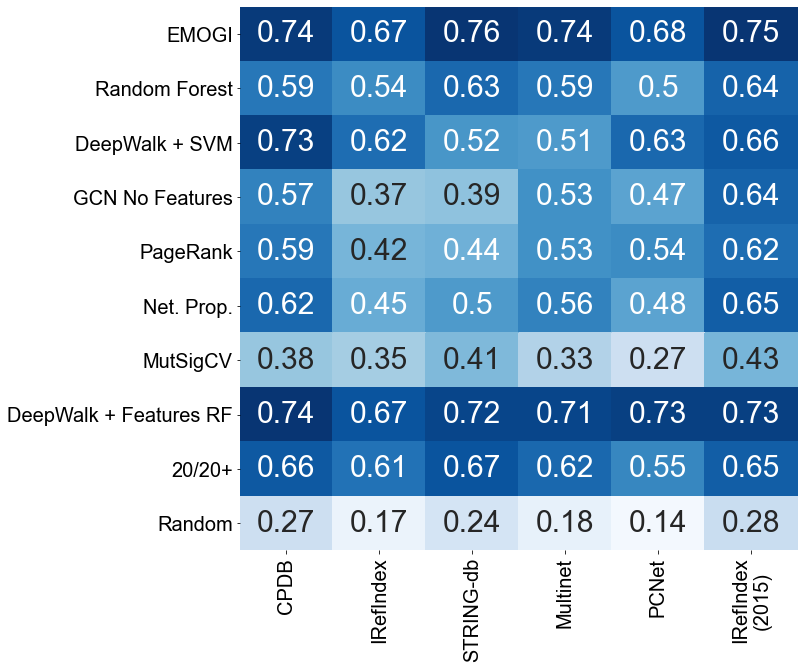

In [19]:
# add random metrics
m_t = metrics_all.T
m_t['Random'] = random_metrics
metrics_all = m_t.T

fig = plt.figure(figsize=(10, 10))
cmap = sns.color_palette("Blues", n_colors=50)
sns.heatmap(metrics_all, cbar=False, cmap=cmap, cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
            annot=True, annot_kws={"size": 30, 'weight': 'medium'})
_ = plt.gca().set_xticklabels(metrics_all.columns, rotation=90, fontsize=20)
_ = plt.gca().set_yticklabels(metrics_all.index, rotation=0, fontsize=20)
#tool_colors = ["darkred", "darkorange", "darkgreen", "darkblue", "grey", "purple"]
#[t.set_color(c) for (c,t) in zip(tool_colors, plt.gca().yaxis.get_ticklabels())]
fig.savefig('/project/gcn/diseasegcn/data/GCN/training/final_TCGA_all_networks/aupr_heatmap_rev1.svg',
            bbox_inches='tight')
#fig.savefig('/project/gcn/diseasegcn/data/GCN/training/Rev1_CNA_separated_all_networks/aupr_heatmap.svg',
#            bbox_inches='tight')

In [20]:
metrics_all.median(axis=1)

EMOGI                    0.740
Random Forest            0.587
DeepWalk + SVM           0.624
GCN No Features          0.499
PageRank                 0.534
Net. Prop.               0.530
MutSigCV                 0.366
DeepWalk + Features RF   0.722
20/20+                   0.634
Random                   0.210
dtype: float64

## Overlap of Predictions from Different Tools

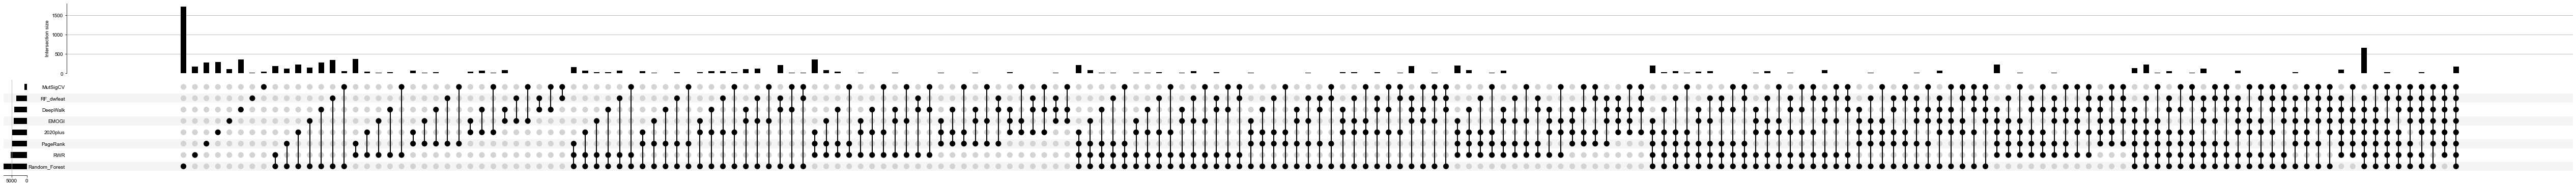

In [59]:
# 1. load data and compute cutoffs for all tools
#model_dir = os.path.join(dir_cpdb, 'multiomics')
model_dir = dir_cpdb
data = postprocessing.get_training_data(model_dir)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
performance_cpdb['Name'] = performance_cpdb.index # needed for cutoff computation
performance_cpdb['label'] = y_test

all_cutoffs = {}
for col in performance_cpdb.drop(['ID', 'Name', 'label'], axis=1).columns:
    cutoff = postprocessing.get_optimal_cutoff(performance_cpdb, node_names, test_mask, y_test, colname=col)
    all_cutoffs[col] = cutoff

# 2. compute positive sets for all tools
pos_predicted = {}
for col in performance_cpdb.drop(['ID', 'Name', 'label'], axis=1).columns:
    pos_pred = performance_cpdb[col] >= all_cutoffs[col]
    pos_predicted[col] = list(performance_cpdb[pos_pred].Name)

# 3. compute and display overlaps between all tools
plot_input = upsetplot.from_contents(pos_predicted)
fig = plt.figure(figsize=(20, 15))
upsetplot.plot(plot_input, subset_size='auto', fig=fig)
fig.savefig(os.path.join(model_dir, 'overlap_tool_prediction.svg'))

## Compute the Amount of Missed Cancer Genes when Leaving Out Data
Next, we want to compute quantitatively how many cancer genes we don't predict with EMOGI when we leave out certain data types.
We therefore either look at the omics levels individually or at combinations of two of them and compare them to the full EMOGI multiomics model.

In [21]:
missed_single_omics = {}
for omics_subset in os.listdir(single_omics_dir):
    training_dir = os.path.join(single_omics_dir, omics_subset)
    if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
        data = postprocessing.get_training_data(training_dir)
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        pred = postprocessing.load_predictions(training_dir)
        cutoff = postprocessing.get_optimal_cutoff(pred, node_names, test_mask, y_test, method='IS', colname='Prob_pos')
        print ("[{}] Predictions: {}\tcutoff: {}".format(omics_subset, (pred.Prob_pos > cutoff).sum(), cutoff))
        #pred = pred[y_test]
        neg_pred = pred[pred.Prob_pos >= cutoff]
        #neg_pred = pred.head(1000)
        #print (neg_pred.label.sum(), neg_pred.shape[0])
        missed_single_omics[omics_subset] = [neg_pred.label.sum(), neg_pred.shape[0]]

# get multiomics
data = postprocessing.get_training_data(dir_cpdb)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
pred = postprocessing.load_predictions(dir_cpdb)
cutoff = postprocessing.get_optimal_cutoff(pred, node_names, test_mask, y_test, method='IS', colname='Prob_pos')
print ("[Multiomics] Predictions: {}\tcutoff: {}".format((pred.Prob_pos > cutoff).sum(), cutoff))
neg_pred = pred[pred.Prob_pos >= cutoff]
#neg_pred = pred.head(1000)
missed_single_omics['multiomics'] = [neg_pred.label.sum(), neg_pred.shape[0]]
missed_cancer_gene_df = pd.DataFrame(missed_single_omics)

[no_snvs_cnasep_rev1] Predictions: 3931	cutoff: 0.861
[no_meth_cnasep_rev1] Predictions: 3701	cutoff: 0.843
[no_ge_cnasep_rev1] Predictions: 3765	cutoff: 0.767
[no_cna_cnasep_rev1] Predictions: 3892	cutoff: 0.605
[cnas] Predictions: 3589	cutoff: 0.93
[mutations] Predictions: 3557	cutoff: 0.9410000000000001
[expression] Predictions: 4100	cutoff: 0.894
[methylation] Predictions: 3598	cutoff: 0.785
[Multiomics] Predictions: 3704	cutoff: 0.809


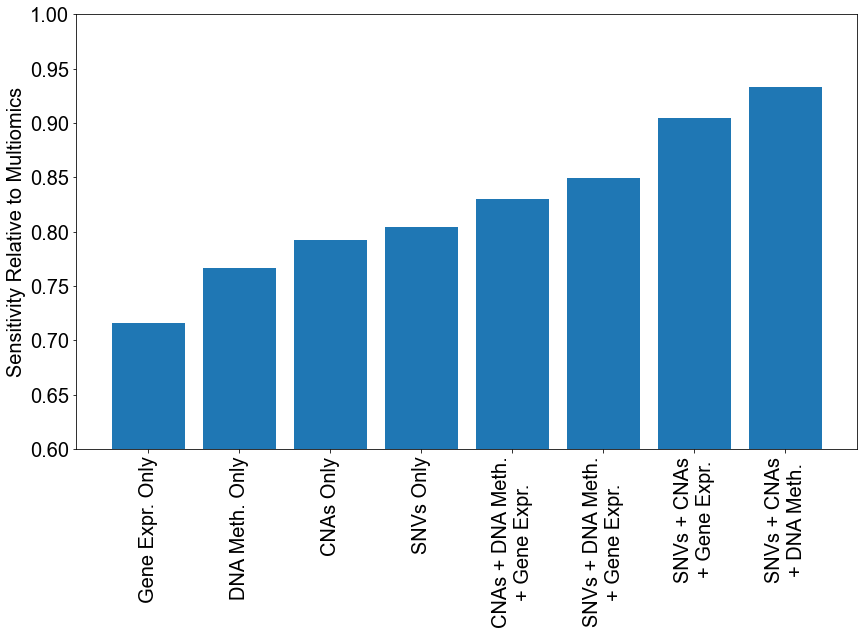

In [23]:
sensitivity = missed_cancer_gene_df.iloc[0, :].div(missed_cancer_gene_df.iloc[1, :])
rel_to_multiomics = sensitivity.div(sensitivity['multiomics'], axis=0)
rel_to_multiomics.drop('multiomics', axis=0, inplace=True)

to_plot = rel_to_multiomics.sort_values(ascending=True)

fig = plt.figure(figsize=(14, 8))
plt.bar(x=list(range(rel_to_multiomics.shape[0])), height=to_plot)

mapping = {'mutations': 'SNVs Only', 'methylation': 'DNA Meth. Only',
           'cnas': 'CNAs Only', 'expression': 'Gene Expr. Only',
           'no_snvs_cnasep_rev1': 'No SNVs', 'no_meth_cnasep_rev1': 'No DNA Meth.',
           'no_ge_cnasep_rev1': 'No Gene Expr.', 'no_cna_cnasep_rev1': 'No Copy Number'}

mapping = {'mutations': 'SNVs Only', 'methylation': 'DNA Meth. Only',
           'cnas': 'CNAs Only', 'expression': 'Gene Expr. Only',
           'no_snvs_cnasep_rev1': 'CNAs + DNA Meth.\n+ Gene Expr.',
           'no_meth_cnasep_rev1': 'SNVs + CNAs\n+ Gene Expr.',
           'no_ge_cnasep_rev1': 'SNVs + CNAs\n+ DNA Meth.',
           'no_cna_cnasep_rev1': 'SNVs + DNA Meth.\n+ Gene Expr.'}

_ = plt.xticks(np.arange(rel_to_multiomics.shape[0]),
               labels=[mapping[i] for i in to_plot.index],
               rotation=90, fontsize=20)
_ = plt.yticks(fontsize=20)
#_ = plt.ylabel('% of Recovered KCGs in top 1000\nPredictions Relative to Multiomics', fontsize=20)
#_ = plt.ylabel('% of Recovered KCGs\nRelative to Multiomics', fontsize=20)
_ = plt.ylabel('Sensitivity Relative to Multiomics', fontsize=20)
plt.ylim([0.6, 1])
fig.savefig(os.path.join(single_omics_dir, 'sensitivity_subomics.pdf'), bbox_inches="tight")

## Prediction Performance for Single (and Dual) Omics Data

In [22]:
np.array(gcn_mo)

array([list([]),
       list([0.8679425657087794, 0.8702052674049712, 0.8654195987892579, 0.8744555646375387, 0.8658658493374349, 0.8713510646081996, 0.8717557110883851, 0.867115420904746, 0.8707885556791768, 0.8724704679948752]),
       list([0.711838813767481, 0.7181327589776247, 0.7072792847184686, 0.7182358547735376, 0.7153137719585375, 0.7409676040410815, 0.7282357491333266, 0.7226453447873704, 0.7331587167528872, 0.7088070739892276]),
       list([0.8679425657087794, 0.8702052674049712, 0.8654195987892579, 0.8744555646375387, 0.8658658493374349, 0.8713510646081996, 0.8717557110883851, 0.867115420904746, 0.8707885556791768, 0.8724704679948752]),
       list([0.6378300120774254, 0.6332332432414303, 0.6318779011641126, 0.6403911770860556, 0.6407608768486012, 0.6556068281386572, 0.643397745287767, 0.641443289894699, 0.6460270760676344, 0.648619483642222])],
      dtype=object)

In [27]:
metric_of_choice = 'aupr'
#gcn_training_path = dir_cpdb
gcn_training_path = single_omics_dir#'../data/GCN/training/leaveoneout_omics_CPDB_rev1/'
used_network = 'CPDB'
#reference = 'multiomics' # the reference training to use for the competing methods
reference = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
consider_negatives = True

# get metrics for GCN
gcn_mo = get_metrics_for_single_training(reference, negatives=consider_negatives, metric=metric_of_choice,
                                         independent_datasets=True, errorbars=True)
gcn_all = get_metrics_for_training(gcn_training_path, negatives=consider_negatives, metric=metric_of_choice,
                                   independent_datasets=True, errorbars=True)
gcn_all[0].append(np.array(gcn_mo)[:, 5:])
gcn_all[1].append('Multiomics')
gcn_all_array = np.array(gcn_all[0])
flattened_dfs = []
for cv_run in range(gcn_all_array.shape[-1]):
    df = pd.DataFrame(gcn_all_array[:, :, cv_run], index=gcn_all[1],
                      columns=['NCG_Known', 'NCG_Cand', 'OncoKB', 'ONGene', 'Bailey'])
    df['cv'] = cv_run
    flattened_dfs.append(df)
gcn_metrics = pd.concat(flattened_dfs)
gcn_metrics['Network'] = used_network
gcn_metrics['Method'] = gcn_metrics.index

# get random metrics
def _get_random_metric(model_dir, dataset, metric='recall', negatives=False):
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    if negatives:
        test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
        denom = test_neg.sum() + len(dataset)
    else:
        denom = network.shape[0]

    if metric.upper() == 'AUPR' or metric.upper() == 'PRECISION':
        random_performance = len(dataset) / denom
    elif metric.upper() == 'RECALL':
        return 0.5 # assuming that the classifier has probability of 0.5 to predict positive
    elif metric.upper() == 'F1':
        rand_precision = len(dataset) / denom
        rand_recall = 0.5
        random_performance = 2 * ( (rand_precision*rand_recall) / (rand_precision + rand_recall) )
    else:
        print ("Metric {} not understood".format(metric))
    return random_performance

all_sets = get_cancer_genes_for_net(reference)
rand_perfs = {}
count = 0
for i in ['NCG Known\nCancer Genes', 'NCG Candidate\nCancer Genes', 'OncoKB Genes\n(not in NCG)',
          'Oncogenes\n(ONGene)', 'Bailey et al.\n(2018)']:
    rand_perfs[i] = _get_random_metric(reference, all_sets[count], metric=metric_of_choice, negatives=consider_negatives)
    count += 1

In [34]:
rand_network_path = '../data/GCN/training/2019_08_27_11_32_33/Random_powerlaw_perturbation/'
rand_net_metrics = get_metrics_for_single_training(rand_network_path, metric='aupr',
                                                   negatives=consider_negatives, errorbars=True,
                                                   independent_datasets=True)
rand_net_df = pd.DataFrame(np.array(rand_net_metrics),
                           index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'ONGene', 'Bailey'],
                           columns=['CV_{}'.format(i) for i in range(5)]
                          ).T
rand_net_df['Network'] = 'CPDB'
rand_net_df['Method'] = 'Randomized Network'
rand_net_df['cv'] = range(5)
gcn_metrics = pd.concat((gcn_metrics, rand_net_df))

../data/GCN/training/leaveoneout_omics_CPDB_rev1/aupr_omicssubsets_withnegatives.svg


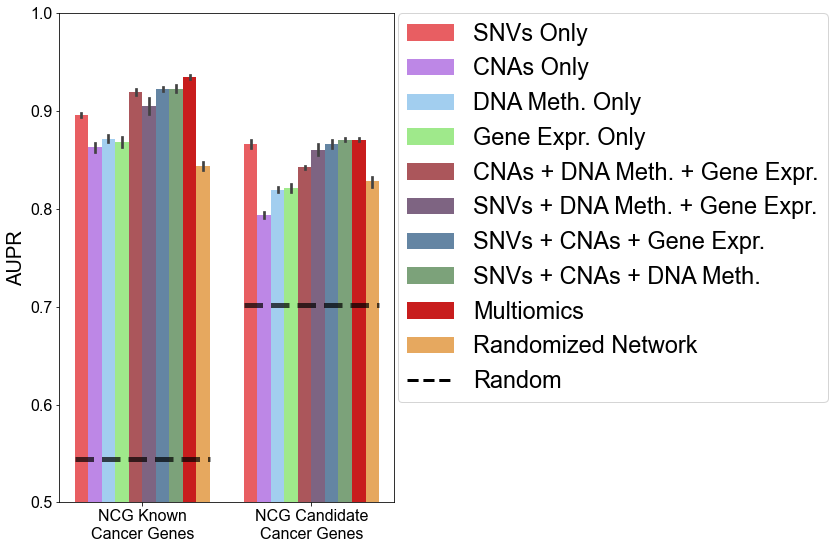

In [36]:
fig = plt.figure(figsize=(6, 9))
replace_dict = {'expression': 'Gene Expression', 'methylation': 'DNA Methylation',
                'mutations': 'Mutation Freq.', 'cnas': 'Copy Number Changes',
                'Multiomics': 'Multi-Omics', 'mutation_expression': 'Mutations & Expression',
                'methylation_expression': 'DNA Meth. & Expression',
                'methylation_mutation': 'DNA Meth. & Mutations.',
                'no_cna_cnasep_rev1': 'No Copy Number', 'no_ge_cnasep_rev1': 'No Gene Expr.',
                'no_meth_cnasep_rev1': 'No DNA Meth.', 'no_snvs_cnasep_rev1': 'No SNVs'
               }

replace_dict = {'mutations': 'SNVs Only', 'methylation': 'DNA Meth. Only',
                'cnas': 'CNAs Only', 'expression': 'Gene Expr. Only',
                'no_snvs_cnasep_rev1': 'CNAs + DNA Meth. + Gene Expr.',
                'no_meth_cnasep_rev1': 'SNVs + CNAs + Gene Expr.',
                'no_ge_cnasep_rev1': 'SNVs + CNAs + DNA Meth.',
                'no_cna_cnasep_rev1': 'SNVs + DNA Meth. + Gene Expr.'}

col_replace_dict = {'NCG_Known': 'NCG Known\nCancer Genes',
                    'NCG_Cand': 'NCG Candidate\nCancer Genes',
                    'OncoKB': 'OncoKB Genes\n(not in NCG)',
                    'ONGene': 'Oncogenes\n(ONGene)', 'Bailey': 'Bailey et al.\n(2018)'
                   }
gcn_metrics_copy = gcn_metrics.copy().drop(['OncoKB', 'ONGene', 'Bailey'], axis=1)
gcn_metrics_copy.rename(mapper=col_replace_dict, axis=1, inplace=True)
metrics_melted = gcn_metrics_copy.drop('Network', axis=1).melt(id_vars=['Method', 'cv'])
metrics_melted.Method = metrics_melted.Method.replace(replace_dict)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange","amber", "faded green",
                                                       "dusty purple", "pink",  "black", "light green", "dark blue", "light blue", "light yellow"])
colors = sns.xkcd_palette(["light red", "light purple", "light blue", "light green",
                           "dusty red", "dusty purple", "dusty blue", "dusty green", "red", "light orange"])

hue_order = ['Mutation Freq.', 'Copy Number Changes', 'DNA Methylation', 'Gene Expression',
             'No SNVs', 'No Copy Number', 'No DNA Meth.', 'No Gene Expr.', 'Multi-Omics', 'Randomized Network']

hue_order = ['SNVs Only', 'CNAs Only', 'DNA Meth. Only', 'Gene Expr. Only', 'CNAs + DNA Meth. + Gene Expr.',
             'SNVs + DNA Meth. + Gene Expr.', 'SNVs + CNAs + Gene Expr.', 'SNVs + CNAs + DNA Meth.',
             'Multiomics', 'Randomized Network']


p = sns.barplot(data=metrics_melted, x='variable', y='value', hue='Method', palette=colors,
                hue_order=hue_order)
#_ = sns.swarmplot(data=metrics_melted, x='variable', y='value', hue='Method')

group = 0
for group_name in metrics_melted.variable.unique():
    plt.plot([group-0.4, group+0.4], [rand_perfs[group_name], rand_perfs[group_name]],
             ls='--', lw=5, alpha=.7, c='black')
    group += 1

rand_handle = Line2D([0], [0], color='black', linewidth=3, linestyle='--')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(rand_handle)
labels.append('Random')

plt.ylabel('{}'.format(metric_of_choice.upper()), fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=2,
                    markerscale=2.5, handles=handles, labels=labels)
plt.ylim([0.5, 1])
f_name = os.path.join(gcn_training_path, '{}_omicssubsets{}.svg'.format(metric_of_choice,
                                                                        '_withnegatives' if consider_negatives else '')
                     )
print (f_name)
#fig.savefig(f_name, bbox_inches='tight')

In [28]:
if 'methylation_expression' in gcn_metrics_copy.index: # old data
    statistic, pval = scipy.stats.ttest_ind(gcn_metrics_copy[gcn_metrics_copy.index == 'methylation_expression']['NCG Known\nCancer Genes'],
                                            gcn_metrics_copy[gcn_metrics_copy.index == 'methylation']['NCG Known\nCancer Genes']
                                           )
    print ("P-value of two-sided t-test between AUPR of Multi-Omics and EMOGI without Copy Number Models on CCGs: {}".format(pval))

In [29]:
statistic, pval = scipy.stats.ttest_ind(gcn_metrics_copy[gcn_metrics_copy.index == 'no_cna_cnasep_rev1']['NCG Candidate\nCancer Genes'],
                                        gcn_metrics_copy[gcn_metrics_copy.index == 'Multiomics']['NCG Candidate\nCancer Genes']
                                       )
print ("P-value of two-sided t-test between AUPR of Multi-Omics and EMOGI without Copy Number Models on CCGs: {}".format(pval))

P-value of two-sided t-test between AUPR of Multi-Omics and EMOGI without Copy Number Models on CCGs: 0.017035756707175737


In [32]:
statistic, pval = scipy.stats.ttest_ind(gcn_metrics_copy[gcn_metrics_copy.index == 'no_ge_cnasep_rev1']['NCG Known\nCancer Genes'],#['NCG Candidate\nCancer Genes'],
                                        gcn_metrics_copy[gcn_metrics_copy.index == 'Multiomics']['NCG Known\nCancer Genes']#['NCG Candidate\nCancer Genes']
                                       )
print ("P-value of two-sided t-test between AUPR of Multiomics and EMOGI without Gene Expression Models on KCGs: {}".format(pval))

statistic, pval = scipy.stats.ttest_ind(gcn_metrics_copy[gcn_metrics_copy.index == 'no_ge_cnasep_rev1']['NCG Candidate\nCancer Genes'],#['NCG Candidate\nCancer Genes'],
                                        gcn_metrics_copy[gcn_metrics_copy.index == 'Multiomics']['NCG Candidate\nCancer Genes']#['NCG Candidate\nCancer Genes']
                                       )
print ("P-value of two-sided t-test between AUPR of Multiomics and EMOGI without Gene Expression Models on CCGs: {}".format(pval))

"""
statistic, pval = scipy.stats.ttest_ind(gcn_metrics_copy[gcn_metrics_copy.index == 'no_snvs_cnasep_rev1']['OncoKB Genes\n(not in NCG)'],#['NCG Candidate\nCancer Genes'],
                                        gcn_metrics_copy[gcn_metrics_copy.index == 'Multiomics']['OncoKB Genes\n(not in NCG)']#['NCG Candidate\nCancer Genes']
                                       )
print ("P-value of two-sided t-test between AUPR of Multiomics and EMOGI without SNVs Models on OncoKB: {}".format(pval))

statistic, pval = scipy.stats.ttest_ind(gcn_metrics_copy[gcn_metrics_copy.index == 'no_ge_cnasep_rev1']['Bailey et al.\n(2018)'],#['NCG Candidate\nCancer Genes'],
                                        gcn_metrics_copy[gcn_metrics_copy.index == 'Multiomics']['Bailey et al.\n(2018)']#['NCG Candidate\nCancer Genes']
                                       )
print ("P-value of two-sided t-test between AUPR of Multiomics and EMOGI without Gene Expression Models on Bailey: {}".format(pval))
"""
print ()

P-value of two-sided t-test between AUPR of Multiomics and EMOGI without Gene Expression Models on KCGs: 0.0013992756912936217
P-value of two-sided t-test between AUPR of Multiomics and EMOGI without Gene Expression Models on CCGs: 0.954797267644224



<AxesSubplot:xlabel='Method', ylabel='value'>

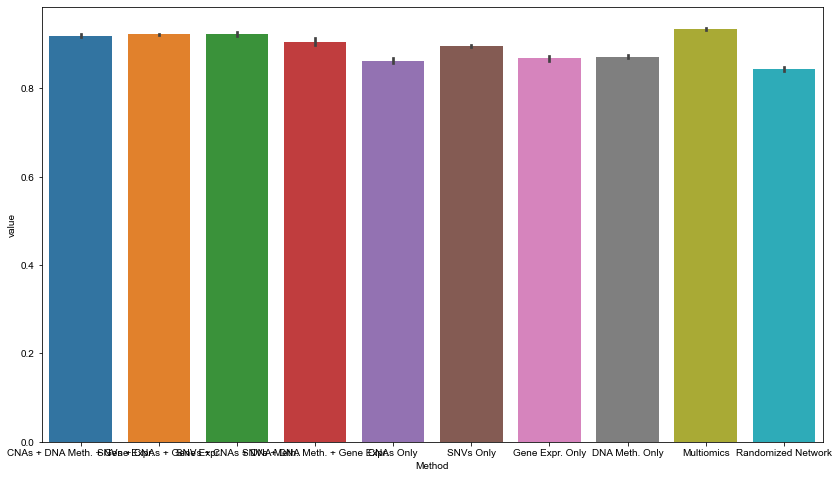

In [37]:
metrics_melted = metrics_melted[metrics_melted.variable == 'NCG Known\nCancer Genes']
fig = plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, y='value', x='Method')

## Omics-Subset Performance on Test Sets

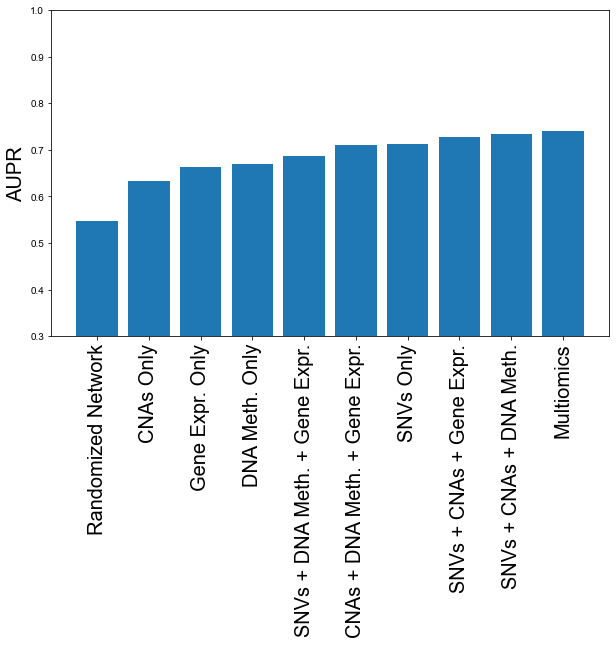

In [35]:
def get_emogi_aupr(training_dir):
    data = postprocessing.get_training_data(training_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    p = postprocessing.load_predictions(training_dir)
    test_genes = node_names[test_mask, 1]
    pred = p[p.Name.isin(test_genes)]
    pred = pred.set_index('Name').reindex(test_genes)
    assert ((pred.index == test_genes).all())
    y_true = y_test[test_mask == 1, 0]
    y_score = pred.Prob_pos
    return average_precision_score(y_true=y_true, y_score=y_score)

all_auprs = []
all_labels = []
for omics_subset in os.listdir(single_omics_dir):
    training_dir = os.path.join(single_omics_dir, omics_subset)
    if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
        all_auprs.append(get_emogi_aupr(training_dir))
        all_labels.append(omics_subset)

all_auprs.append(get_emogi_aupr(dir_cpdb))
all_labels.append('Multiomics')

all_auprs.append(get_emogi_aupr('../data/GCN/training/2020_09_28_12_04_04/Random_powerlaw_perturbation/'))
all_labels.append('Randomized Network')

all_auprs = np.array(all_auprs)
all_labels = np.array(all_labels)
fig = plt.figure(figsize=(10, 6))
sorting = np.argsort(all_auprs)
plt.bar(x=np.arange(len(all_auprs)), height=np.take_along_axis(all_auprs, sorting, axis=0))
_ = plt.xticks(np.arange(len(all_auprs)),
               labels=[replace_dict[i] if i in replace_dict else i for i in np.take_along_axis(all_labels, sorting, axis=0)],
               rotation=90, fontsize=20)
plt.ylabel('AUPR', fontsize=20)
plt.ylim([0.3, 1])
fig.savefig(os.path.join(single_omics_dir, 'test_set_performance_barplot.svg'))

## Plot Performance for Independent Data Sets

In [41]:
metric_of_choice = 'aupr'
datasets = 'main' # 'supplement'

def get_threshold(y_true, y_pred):
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold


training_runs = {'Multinet': dir_multinet,
                 'CPDB': dir_cpdb,
                 'IREF':dir_iref,
                 'STRING-db': dir_string,
                 'IREF (New)': dir_irefnew,
                 'PCNet': dir_pcnet
                }
name2ppiname = {'Multinet': 'Multinet', 'CPDB': 'CPDB', 'IREF': 'IREF', 'IREF (New)': 'IREFNew', 'STRING-db': 'string', 'PCNet': 'PCNet'}
methods = [('EMOGI', 'EMOGI'), ('Random Forest', 'Random_Forest'),
           ('DeepWalk + SVM', 'DeepWalk'), ('GCN No Features', 'GCN_Featureless'),
           ('PageRank', 'PageRank'), ('Net. Prop.', 'RWR'),
           ('MutSigCV', 'MutSigCV'), ('DeepWalk + Features RF', 'RF_dwfeat'), 
           ('20/20+', '2020plus')]
ppi_networks = ['CPDB', 'IREF (New)', 'STRING-db', 'Multinet', 'PCNet', 'IREF']
independent_metrics_all = pd.DataFrame(index=[m[0] for m in methods])


for ppi_network in ppi_networks:
    #model_dir = os.path.join(training_runs[ppi_network], 'multiomics')
    model_dir = training_runs[ppi_network]
    performance_all, performance_test = postprocessing.compute_predictions_competitors(model_dir=model_dir,
                                                                                       network_name=name2ppiname[ppi_network], network_measures=False,
                                                                                       plot_correlations=False, verbose=False)
    
    data = postprocessing.get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # get the datasets
    ncg_known, ncg_cand, oncoKB, ongene, bailey = get_cancer_genes_for_net(model_dir)
    if datasets == 'main':
        kcg1, kcg2 = ongene, oncoKB
    else:
        kcg1, kcg2 = ncg_cand, bailey

    # compute area under PR curve
    metric_values = []
    for name, colname in methods:
        pred = pd.DataFrame(performance_all[colname].rename('Mean_Pred'))
        pred['Name'] = pred.index
        pred['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)
        cutoff = get_threshold(y_true=y_test[test_mask == 1, 0], y_pred=performance_test[colname])
        test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
        train_neg = np.logical_and(np.logical_not(y_train.reshape(-1)), train_mask)
        val_neg = np.logical_and(np.logical_not(y_val.reshape(-1)), val_mask)
        neg_all = np.logical_or(np.logical_or(train_neg, test_neg), val_neg)
        genes_neg = node_names[neg_all, 1] # get the gene names
        kcg1_metric, kcg2_metric = postprocessing.get_metric_score(pred, node_names, kcg1, kcg2, cutoff,
                                                                   None, metric=metric_of_choice)
        metric_values.append([kcg1_metric, kcg2_metric])
    print ("Computations for {} completed!".format(ppi_network))
    independent_metrics_all[ppi_network] = metric_values


independent_metrics_all.columns = ['IRefIndex\n(2015)' if i == 'IREF' else i for i in independent_metrics_all.columns]
independent_metrics_all.columns = ['IRefIndex' if i == 'IREF (New)' else i for i in independent_metrics_all.columns]

/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for CPDB completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF (New) completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for STRING-db completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for Multinet completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for PCNet completed!


/project/gcn/diseasegcn/EMOGI/postprocessing.py:701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF completed!


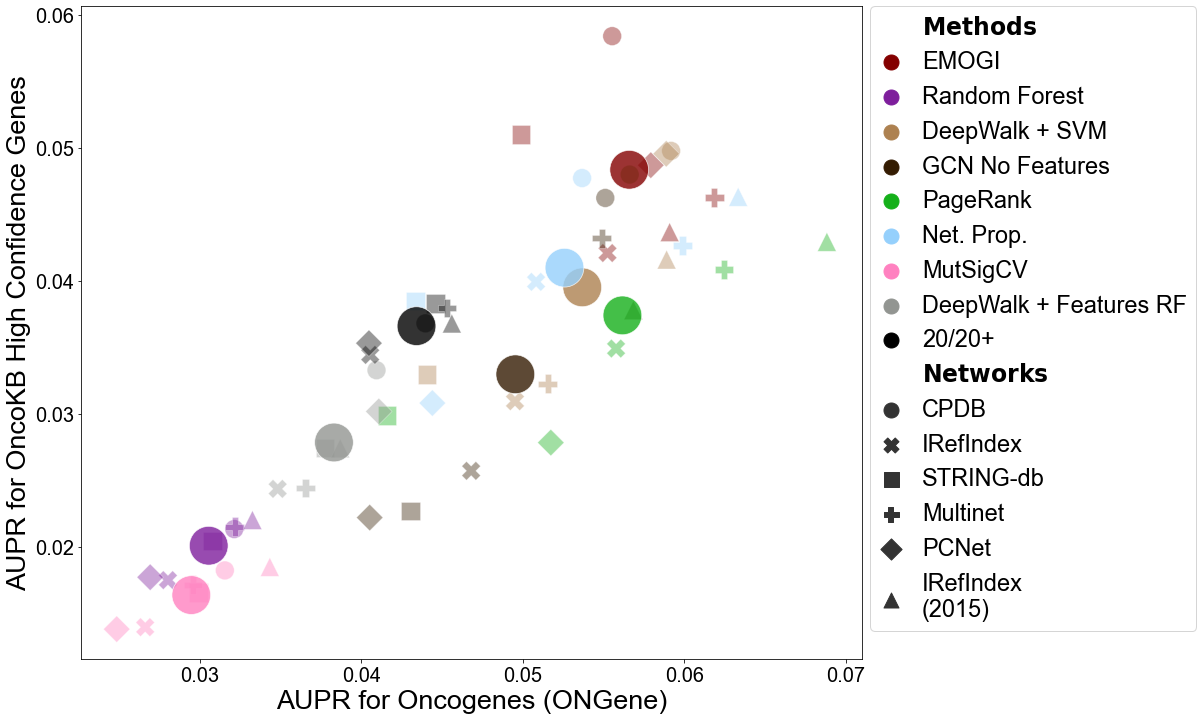

In [42]:
fig = plt.figure(figsize=(14, 12))

independent_metrics_all['Method'] = independent_metrics_all.index
t = independent_metrics_all.melt(id_vars=['Method'])
t['KCG1'] = [i[0] for i in t.value]
t['KCG2'] = [i[1] for i in t.value]

colors = sns.xkcd_palette(["dark red", "purple", "light brown", "dark brown", "green", "light blue", "pink", 'grey', 'black'])

sns.scatterplot(data=t,
                x='KCG1',
                y='KCG2',
                hue='Method',
                style='variable',
                alpha=.4, s=350, palette=colors[:t.Method.nunique()])
sns.scatterplot(data=t.groupby('Method', as_index=False, sort=False).mean(), x='KCG1', y='KCG2', hue='Method',
                palette=colors, s=1500, alpha=.8, legend=False)

plt.tick_params(axis='both', labelsize=20)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)
legend.texts[0].set_text(r"$\bf{Methods}$")
legend.texts[t.Method.nunique()+1].set_text(r"$\bf{Networks}$")

if datasets == 'main':
    plt.xlabel('{} for Oncogenes (ONGene)'.format(metric_of_choice.upper()), fontsize=27)
    plt.ylabel('{} for OncoKB High Confidence Genes'.format(metric_of_choice.upper()), fontsize=27)
    #fig.savefig('../data/pancancer/ensemble_metrics_{}_oncokb_vs_oncogenes_rev1.svg'.format(metric_of_choice),
    #            bbox_inches="tight")
else:
    plt.ylabel('{} for Bailey et al.'.format(metric_of_choice.upper()), fontsize=27)
    plt.xlabel('{} for NCG Candidate Cancer Genes'.format(metric_of_choice.upper()), fontsize=27)
    #fig.savefig('../data/pancancer/ensemble_metrics_{}_bailey_vs_candidates_rev1.svg'.format(metric_of_choice),
    #            bbox_inches="tight")

In [31]:
data = postprocessing.get_training_data(os.path.join(dir_cpdb, 'multiomics'))
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
get_hotnet2_results()['iRefIndex_Frequency']
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes[nodes.Name.isin(get_hotnet2_results()['iRefIndex_Frequency'])].head()

,ID,Name
18,ENSG00000146648,EGFR
20,ENSG00000121879,PIK3CA
88,ENSG00000284792,PTEN
89,ENSG00000141510,TP53
117,ENSG00000165891,E2F7


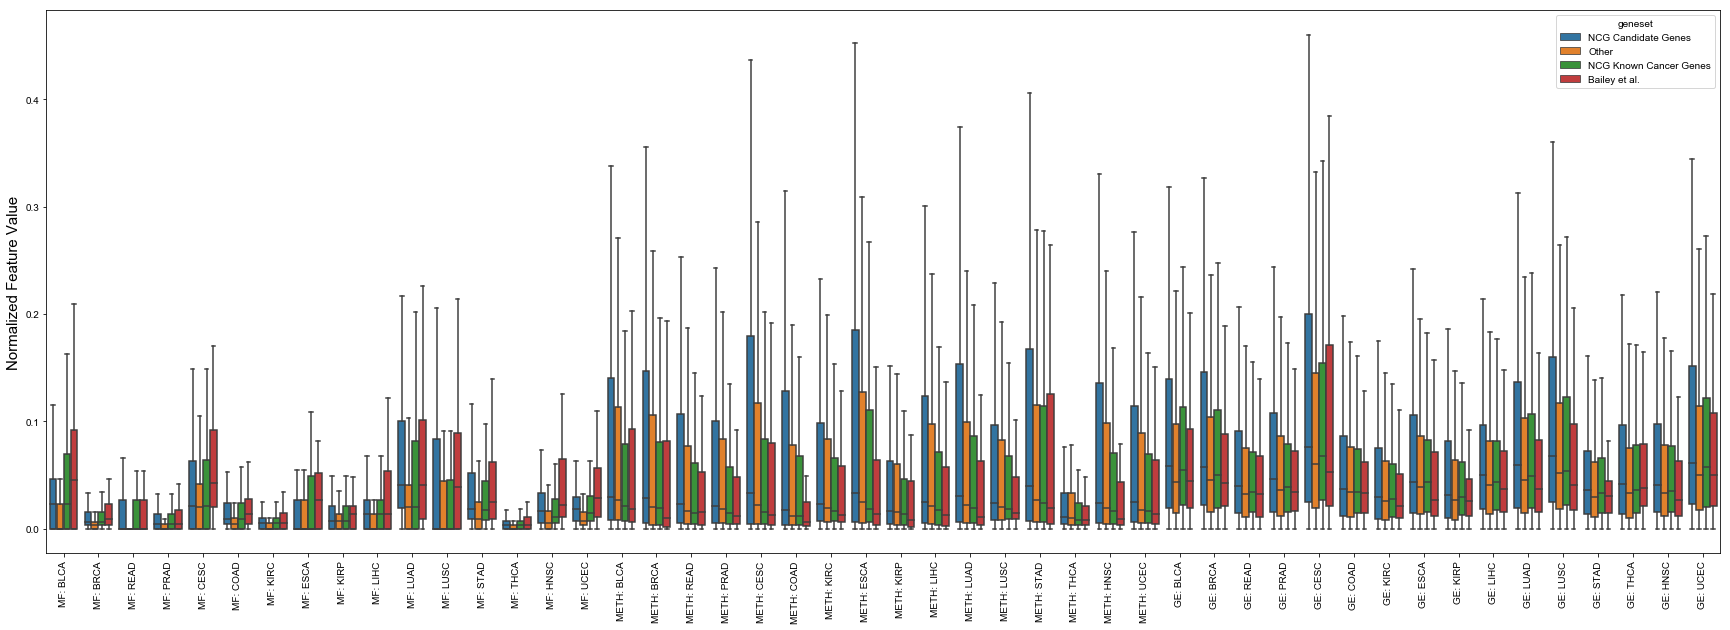

In [32]:
data = postprocessing.get_training_data(os.path.join(dir_cpdb, 'multiomics'))
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
F = pd.DataFrame(features, index=node_names[:, 1], columns=feat_names)

# construct a feature df and melt it
F['geneset'] = 'Other'
F.loc[F.index.isin(ncg_known), 'geneset'] = 'NCG Known Cancer Genes'
F.loc[F.index.isin(ncg_cand), 'geneset'] = 'NCG Candidate Genes'
F.loc[F.index.isin(comprehensive), 'geneset'] = 'Bailey et al.'
x = F.melt(id_vars=['geneset'])

# plot
fig = plt.figure(figsize=(30, 10))
sns.boxplot(data=x, x='variable', y='value', hue='geneset', showfliers=False)
plt.xticks(rotation=90)
plt.ylabel('Normalized Feature Value', fontsize=15)
plt.xlabel(None)
fig.savefig(os.path.join(dir_cpdb, 'feature_distro_genesets.pdf'))

## Diversity of Training Data

In [5]:
data = postprocessing.get_training_data(dir_cpdb)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
y = np.logical_or(np.logical_or(y_train, y_test), y_val)
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
positives = nodes[y]

,ID,Name
18,ENSG00000146648,EGFR
19,ENSG00000138798,EGF
20,ENSG00000121879,PIK3CA
21,ENSG00000145675,PIK3R1
22,ENSG00000197122,SRC
...,...,...
12872,ENSG00000122778,KIAA1549
13298,ENSG00000136169,SETDB2
13378,ENSG00000126010,GRPR
13393,ENSG00000137869,CYP19A1


In [7]:
datasets = {}
#prognostic genes
prognostic_genes = pd.read_excel('../data/pancancer/prognostic_genes/wee_et_al_cnaderived_filtered.xlsx') # based on CNAs
#prognostic_genes = pd.read_csv('../data/pancancer/prognostic_genes/wee_et_al_prognostic_genes.csv', sep='\t')
prognostic_genes.set_index('Gene', inplace=True)
print ("Positives contain {}/{} Prognosis Genes".format((positives.Name.isin(prognostic_genes.index)).sum(),
                                                        prognostic_genes.shape[0]))
datasets['Prognostic'] = positives[positives.Name.isin(prognostic_genes.index)].Name

# metastasis genes
metastatic_genes_df = pd.read_excel('../data/pancancer/priestley_et_al_metastatic/41586_2019_1689_MOESM10_ESM.xlsx', sheet_name=0)
metastatic_genes = metastatic_genes_df.gene.unique()
print ("Positives contain {}/{} Metastasis Genes".format((positives.Name.isin(metastatic_genes)).sum(),
                                                        len(metastatic_genes)))
datasets['Metastasis'] = positives[positives.Name.isin(metastatic_genes)].Name

# Epi-drivers
driverdb_cancer_gene_path = '../data/pancancer/driverdb/'
evidence_drivers = {}
for evidence in ['mutation', 'CNV', 'methylation']:
    driverdb_data = pd.read_csv(os.path.join(driverdb_cancer_gene_path, '{}_download_tab.txt'.format(evidence)), sep='\t')
    drivers = []
    for index, row in driverdb_data.iterrows():
        drivers += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
    evidence_drivers[evidence] = list(set(drivers))
    print ("Positives contain {}/{} {}-drivers".format(positives.Name.isin(drivers).sum(), len(set(drivers)), evidence))
    if not evidence == 'mutation':
        datasets['{}-driver'.format(evidence)] = positives[positives.Name.isin(drivers)].Name
    
# cancer initiation genes
ci_genes = pd.read_csv('../data/pancancer/ongene_tsgene/Human_initiation_genes.txt', sep='\t')
print ("Positives contain {}/{} Initiation Genes".format((positives.Name.isin(ci_genes.GeneSymbol)).sum(),
                                                        len(ci_genes.GeneSymbol.unique())))
datasets['Initiation'] = positives[positives.Name.isin(ci_genes.GeneSymbol)].Name

Positives contain 209/889 Prognosis Genes
Positives contain 277/458 Metastasis Genes
Positives contain 732/14691 mutation-drivers
Positives contain 87/1471 CNV-drivers
Positives contain 109/1284 methylation-drivers
Positives contain 76/177 Initiation Genes


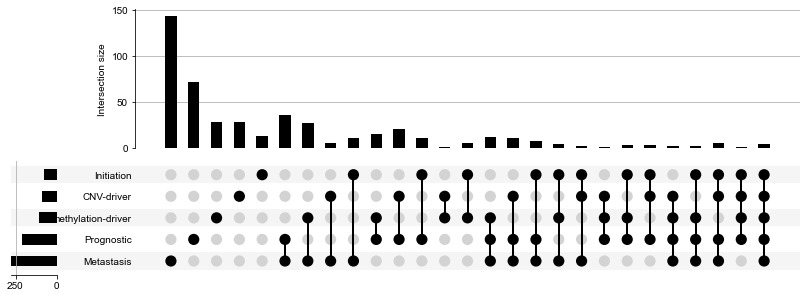

In [8]:
contents = upsetplot.from_contents(datasets)
_ = upsetplot.plot(contents, subset_size='auto')

In [15]:
_, data_file = gcnIO.load_hyper_params(dir_cpdb)
data_file

'../../../../pancancer/rev1_container_all_networks_CNA_separated/CPDB_multiomics_cnaseparate_samesplit.h5'

In [17]:
with h5py.File(os.path.join(dir_cpdb, data_file), 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None
    if 'feature_names' in f:
        feature_names = f['feature_names'][:]
    else:
        feature_names = None
    features_raw = f['features_raw'][:]

In [56]:
F = pd.DataFrame(features_raw, index=node_names[:, 1], columns=feat_names)
omics_only = F.loc[:, F.columns.str.startswith('METH:')]
omics_pos = omics_only[omics_only.index.isin(positives.Name)]
omics_pos[(np.abs(omics_pos) > .2).any(axis=1)].shape

(151, 16)